In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import random
%matplotlib inline

In [2]:
pcd = o3d.io.read_point_cloud("point_cloud.pcd")
# o3d.visualization.draw_geometries([pcd])

In [3]:
def projectToImage(K, P, points, colors, height, width):
    R = P[:, :3]
#     R[:, 1] *= -1
    t = P[:, 3]
    
    dist_coeff = np.zeros((4, 1))
    projected, _ = cv2.projectPoints(points, R, t, K, dist_coeff)
    projected = projected.reshape(-1, 2). astype(np.int)
    
    mask = (
        (0 <= projected[:, 0]) & (projected[:, 0] < width) &
        (0 <= projected[:, 1]) & (projected[:, 1] < height)
    )
    
    img_coord = projected[mask]
    img_color = colors[mask]
    
    return img_coord, img_color

In [4]:
def getPoses():
    poses = []
    with open("poses.txt","r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(" ")
            row = np.array(row).astype('float64')
            poses.append(row.reshape((3, 4)))

    return poses

In [5]:
def getImage(points, color, height, width):
    image = np.zeros((height, width, 3), dtype=color.dtype)
    image[points[:, 1], points[:, 0]] = color
    return image

In [6]:
def DLT(world_points, image_points, k):
    A = []
    for i in range(k):
        u = image_points[i][0]
        v = image_points[i][1]
        x = world_points[i][0]
        y = world_points[i][1]
        z = world_points[i][2]
        row_1 = [0, 0, 0, 0, -x, -y, -z, -1, v*x, v*y, v*z, v]
        row_2 = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u]
        row_3 = [-v*x, -v*y, -v*z, -v, u*x, u*y, u*z, u, 0, 0, 0, 0]
        A.extend([row_1, row_2, row_3])
    A = np.array(A)
    
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    
    print(u.shape, s.shape, vh.shape)
    vh = vh.transpose()
#     print(vh)
    P = vh[:, 11]
    P = P.reshape(3,4)
    print(A.shape)
    
    return P
    

In [7]:
# P = np.array([-9.466844e-01, 2.747540e-02, 3.209888e-01, -1.869050e+02, 3.735473e-02, 9.989978e-01, 2.465901e-02, 1.925132e+00, -3.199896e-01, 3.533474e-02, -9.467619e-01, 4.724980e+01])
# P = np.reshape(P, (3, 4))
poses = getPoses()
P = poses[0]
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]])
height = 370
width = 1226

In [8]:
points = np.asarray(pcd.points) 
colors = np.asarray(pcd.colors)

print(points.shape)

(2007691, 3)


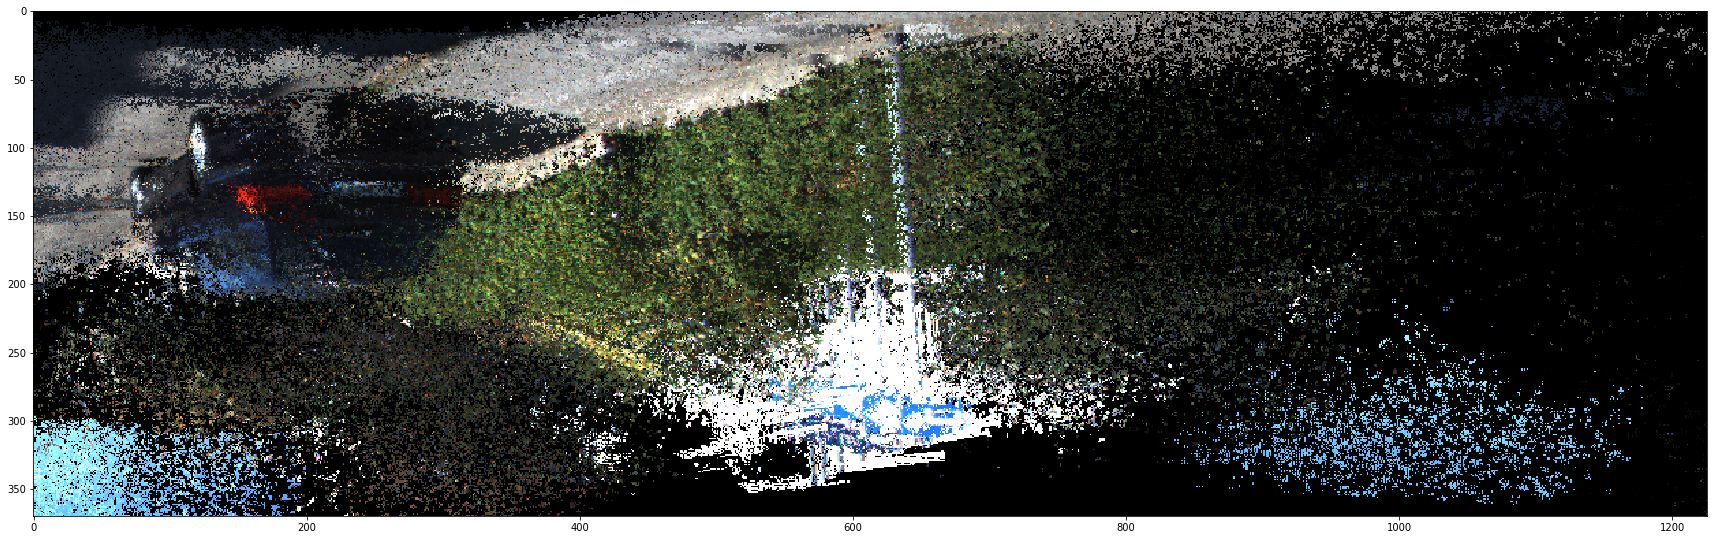

In [9]:
img_coord, img_color = projectToImage(K, P, points, colors, height, width)
img = getImage(img_coord, img_color, height, width)

plt.subplots_adjust(right=4, top=4)
plt.imshow(img)
plt.show()

In [10]:
k = 100
sampling = np.array(random.choices(points, k=k))
# print(sampling.shape)
row = np.ones((k, 1))
# print(sampling.shape, row.shape)
sampling = np.concatenate([sampling, row], axis = 1)
sampled_image = (K @ P @ sampling.T).T
# print(sampled_image.shape, sampled_image[:, 2].shape)

for i in range(k):
    sampled_image[i] /= sampled_image[i, 2]

print(sampling.shape)
print(sampled_image.shape)

# print(sampled_image)

(100, 4)
(100, 3)


In [11]:
# x x PX = 0
print(P/P[2][3])
P_calc = DLT(sampling, sampled_image, k)
P_calc = np.linalg.inv(K) @ P_calc 
print(P_calc/P_calc[2][3])

[[-1.67960222e-02  1.00522255e-03 -7.59334771e-03 -3.45727453e+00]
 [ 7.60155693e-04  1.84288635e-02  7.58232518e-04  3.45244352e-02]
 [ 7.62178367e-03  3.77200469e-04 -1.68089831e-02  1.00000000e+00]]
(300, 12) (12,) (12, 12)
(300, 12)
[[-1.67960222e-02  1.00522255e-03 -7.59334771e-03 -3.45727453e+00]
 [ 7.60155693e-04  1.84288635e-02  7.58232518e-04  3.45244352e-02]
 [ 7.62178367e-03  3.77200469e-04 -1.68089831e-02  1.00000000e+00]]


In [12]:
# def gauss_newton(iters,x,X):
#     '''Assuming x_points and X_points are N*3 and N*4 respectively'''
# #     p = np.random.rand(12,1).reshape((12,1))
#     p = np.array([-1.67960222e-02,  1.00522255e-03, -7.59334771e-03, -3.45727453e+00, \
#                   7.60155693e-04,  1.84288635e-02,  7.58232518e-04,  3.45244352e-02, \
#                   7.62178367e-03,  3.77200469e-04, -1.68089831e-02,  1.00000000e+00])
    
#     for i in range(iters):
#         P = p.reshape((3,4))
#         projected = (P @ X.T)
#         # err is 3*N and has all xi-PXi as columns
#         err = x.T - projected
#         r1 = err[0,:]
#         r2 = err[1,:]
#         r3 = err[2,:]
#         Js = np.vstack((r1,r1,r1,r1,r2,r2,r2,r2,r3,r3,r3,r3))
#         mul = np.vstack((X.T,X.T,X.T))
#         Js = np.multiply(mul,Js)
#         J = np.sum(Js,axis = 1)
#         J = J.reshape((12,1))
#         den = J.T @ J
#         update = (J/den).reshape((12,1))
#         p = p + update
#     return p.reshape((3,4))   

In [13]:
# def gauss_newton(iters,x,X,k):
#     '''Assuming x_points and X_points are N*3 and N*4 respectively'''
# #     p = np.random.rand(12,1).reshape((12,1))
    
#     mu = 0
#     sigma = 10e-4
#     lambd = 10e-2
#     fail = 0
#     success = 0
#     noise = np.random.normal(mu, sigma, 12).reshape((12,1))
#     p = np.array([-1.67960222e-02,  1.00522255e-03, -7.59334771e-03, -3.45727453e+00, \
#                   7.60155693e-04,  1.84288635e-02,  7.58232518e-04,  3.45244352e-02, \
#                   7.62178367e-03,  3.77200469e-04, -1.68089831e-02,  1.00000000e+00]).reshape((12,1))
    
#     p += noise
#     print(p)
# #     for j in range(iters):
        
#     error = 10
# #     prev_error = J.
#     while np.linalg.norm(error) > 10e-2:
#         P = p.reshape((3,4))
#         projected = (P @ X.T)
#         # e is 3*N and has all xi-PXi as columns
#         e = x.T - projected
#         update = np.zeros(12).reshape((12,1))
#         for i in range(k):
#             r1 = np.array([-X[i,0],-X[i,1],X[i,2],-1,0,0,0,0,0,0,0,0])
#             r2= np.array([0,0,0,0,-X[i,0],-X[i,1],X[i,2],-1,0,0,0,0])
#             r3= np.array([0,0,0,0,0,0,0,0,-X[i,0],-X[i,1],X[i,2],-1])                                     
#             J = np.stack((r1,r2,r3))
#             update += (np.linalg.pinv(J.T @ J) @ J.T @ e[:,i]).reshape((12,1)) 
            
#         term = J.T @ e
#         error = np.sum(term, axis = 1)
        
# #         if(prev_error > error):
# #             p = p - update
# #             lambd *= 0.5
# #             success = success + 1
# #         else:
# #             lambd*= 4
# #             fail = fail + 1
# #         prev_error = error
    
# #     print('Number of success: {}'.format(success))
# #     print('Number of fail: {}'.format(fail))
#     return p.reshape((3,4))

In [14]:
def gauss_newton(iters,x,X,k):
    '''Assuming x_points and X_points are N*3 and N*4 respectively'''
  
    mu = 0
    sigma = 10e-4
    lambd = 10e-2
    fail = 0
    success = 0
    noise = np.random.normal(mu, sigma, 12).reshape((12,1))
    p = np.array([-1.67960222e-02,  1.00522255e-03, -7.59334771e-03, -3.45727453e+00, \
                  7.60155693e-04,  1.84288635e-02,  7.58232518e-04,  3.45244352e-02, \
                  7.62178367e-03,  3.77200469e-04, -1.68089831e-02,  1.00000000e+00]).reshape((12,1))
    
    p += noise
        
    error = 10
#     while np.linalg.norm(error) > 10e-2:
    for q in range(iters):    
        P = p.reshape((3,4))
        projected = (P @ X.T)
        # e is 3*N and has all xi-PXi as columns
        e = (x.T - projected).T.reshape((3*k,1))
        # after reshaping e becomes 3N*1 
        J = np.zeros(36).reshape((3,12))
        
        for i in range(k):
            r1 = np.array([-X[i,0],-X[i,1],X[i,2],-1,0,0,0,0,0,0,0,0]).reshape((1,12))
            r2= np.array([0,0,0,0,-X[i,0],-X[i,1],X[i,2],-1,0,0,0,0]).reshape((1,12))            
            r3= np.array([0,0,0,0,0,0,0,0,-X[i,0],-X[i,1],X[i,2],-1]).reshape((1,12))                                     
            temp = np.vstack((r1,r2,r3))
            J = np.vstack((J,temp))
        J = J[3:]
        update = (np.linalg.pinv(J.T @ J) @ J.T @ e).reshape((12,1)) 
        p = p - update   
    
    return p.reshape((3,4))

In [15]:
P_gauss = gauss_newton(300,sampled_image,sampling,k)
print(P_gauss/P_gauss[2][3])

[[ 1.95639505e-02 -1.42467027e-01 -1.04597435e+14 -6.37598928e+01]
 [-6.95678509e-04  5.28041152e-03  3.87805892e+12  2.27523256e+00]
 [-7.21298084e-04  2.16137858e-03  1.72856382e+12  1.00000000e+00]]


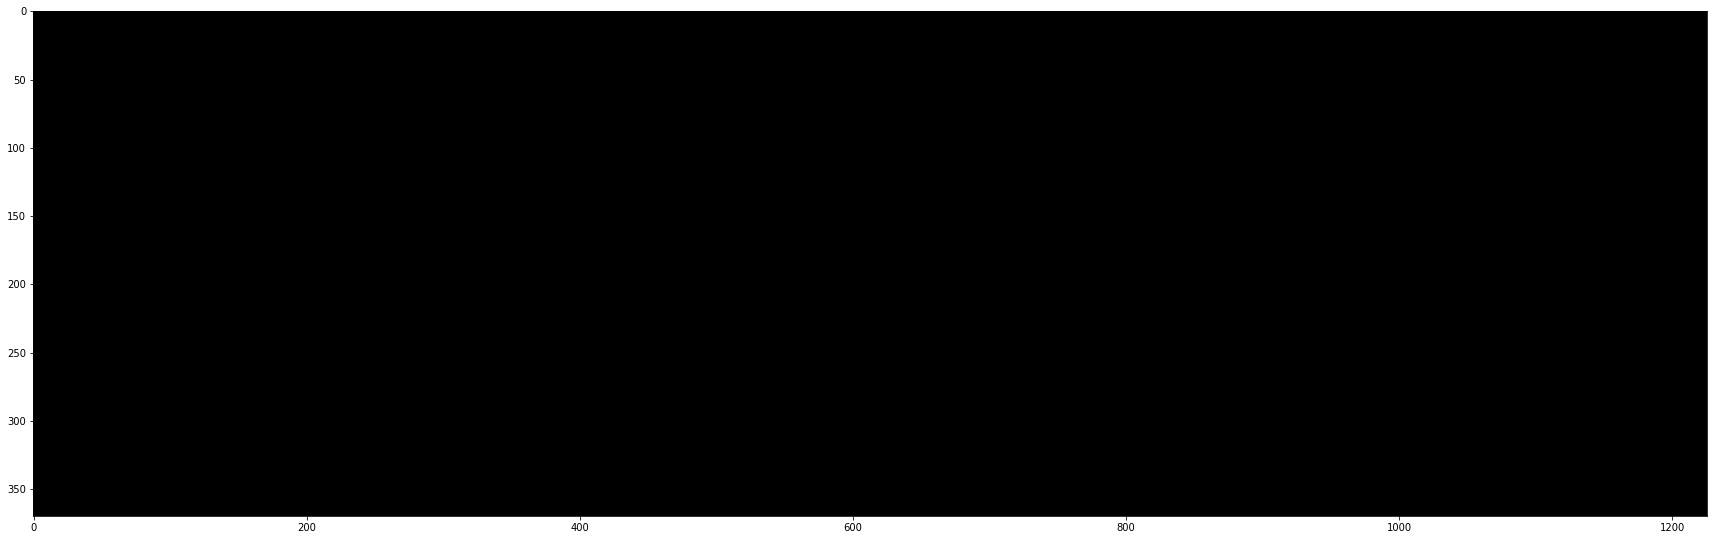

In [16]:
img_coord, img_color = projectToImage(K, P_gauss, points, colors, height, width)
img = getImage(img_coord, img_color, height, width)

plt.subplots_adjust(right=4, top=4)
plt.imshow(img)
plt.show()